In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  8 05:47:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
# import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing Dataset

In [ ]:
training = '/content/drive/MyDrive/Data'
# validation = '/content/drive/MyDrive/Dataset/No DR'
testing = '/content/drive/MyDrive/Test'

train_batches = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True, validation_split=0.2, rescale=1./255).flow_from_directory(directory=training, target_size=(224,224), class_mode='binary', batch_size=32, subset='training')
valid_batches = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, vertical_flip=True, validation_split=0.2, rescale=1./255).flow_from_directory(directory=training, target_size=(224,224), class_mode = 'binary', batch_size=32, subset='validation')
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=testing, target_size=(224,224), batch_size=32, class_mode = 'binary', shuffle=False)

Found 27467 images belonging to 2 classes.
Found 6865 images belonging to 2 classes.
Found 790 images belonging to 2 classes.


In [ ]:
imgs, labels = next(train_batches)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # img = img.swapaxes(0,1)
        # img = img.swapaxes(1,2)
        ax.imshow(img)       
        ax.axis('off')
    plt.tight_layout()
    plt.show()

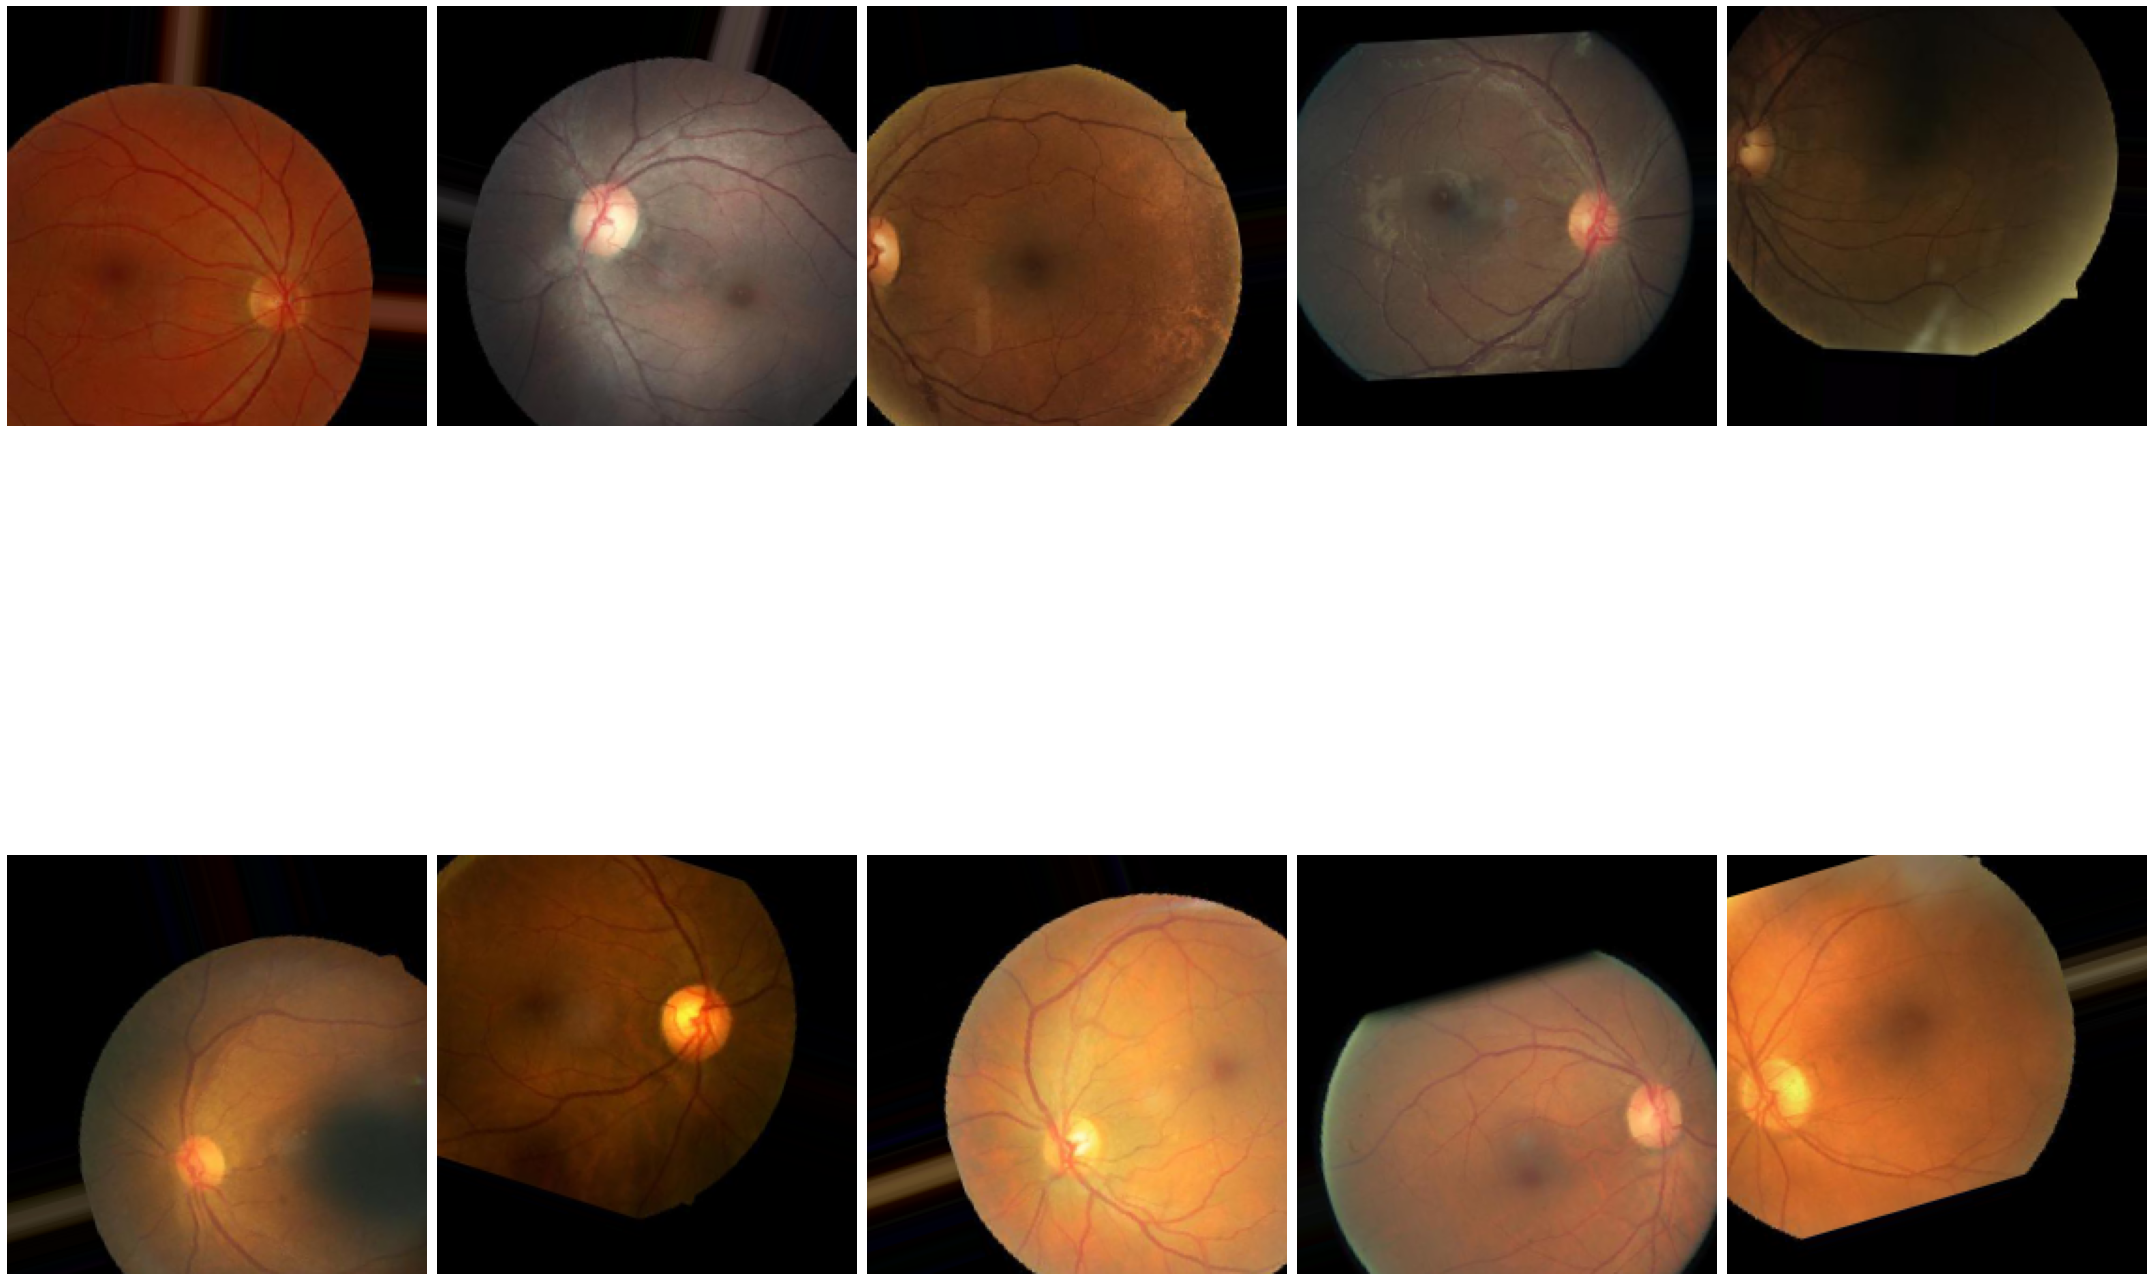

In [ ]:
plotImages(imgs)

## Defining Model

In [ ]:
# num_classes = 2

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    (Dropout(0.3)),
    Dense(256, activation='relu'),
    (Dropout(0.5)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

## Compile Model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Callbacks

In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights = True, verbose=1)

## Training and Validating Model

In [ ]:
history = model.fit(x=train_batches,
                    steps_per_epoch=train_batches.samples // 32,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.samples // 32,
                    epochs=200,
                    verbose=1,
                    callbacks=[stopping]
)

Epoch 1/200
858/858 [==============================] - 3459s 4s/step - loss: 0.5799 - accuracy: 0.7401 - val_loss: 0.5732 - val_accuracy: 0.7402
Epoch 2/200
858/858 [==============================] - 444s 517ms/step - loss: 0.5736 - accuracy: 0.7399 - val_loss: 0.5726 - val_accuracy: 0.7405
Epoch 3/200
858/858 [==============================] - 449s 523ms/step - loss: 0.5734 - accuracy: 0.7399 - val_loss: 0.5734 - val_accuracy: 0.7401
Epoch 4/200
858/858 [==============================] - 451s 526ms/step - loss: 0.5732 - accuracy: 0.7403 - val_loss: 0.5735 - val_accuracy: 0.7396
Epoch 5/200
858/858 [==============================] - 447s 521ms/step - loss: 0.5733 - accuracy: 0.7400 - val_loss: 0.5731 - val_accuracy: 0.7401
Epoch 6/200
858/858 [==============================] - 448s 521ms/step - loss: 0.5734 - accuracy: 0.7400 - val_loss: 0.5731 - val_accuracy: 0.7405
Epoch 7/200
858/858 [==============================] - 453s 527ms/step - loss: 0.5731 - accuracy: 0.7401 - val_loss: 0.5

## Displaying Training and Validation Graphs

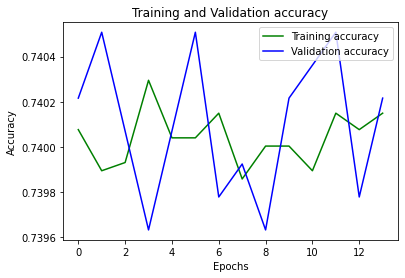

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

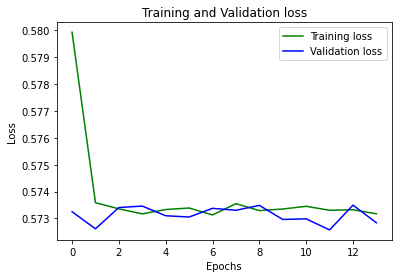

In [ ]:
train_acc = history.history['loss']
val_acc = history.history['val_loss']
plt.plot(train_acc, 'g', label='Training loss')
plt.plot(val_acc, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## ROC Curve

In [ ]:
# make a prediction
y_pred_keras = model.predict_generator(test_batches, verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_batches.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


25/25 [==============================] - 193s 8s/step


0.5

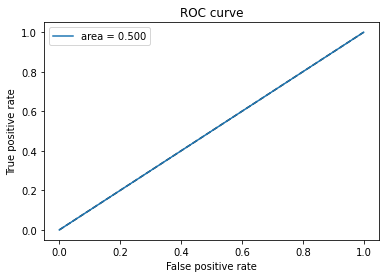

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Save Model

In [ ]:
model.save('customModel.h5')

In [ ]:
model.save('custom_model')

In [ ]:
# path to the SavedModel directory
saved_model_dir = 'custom_model'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)